# [Contents Based Filtering](https://tech.kakao.com/2021/12/27/content-based-filtering-in-kakao/)
- 사용자가 특정 아이템을 선호하는 경우 그 아이템과 비슷한 컨텐츠를 가진 다른 아이템을 추천해주는 방식이다.   
- 컨텐츠 자체를 분석하는 방식이기 때문에 초기의 사용자 행동 데이터가 적도라도 추천할 수 있는 장점이 있다.

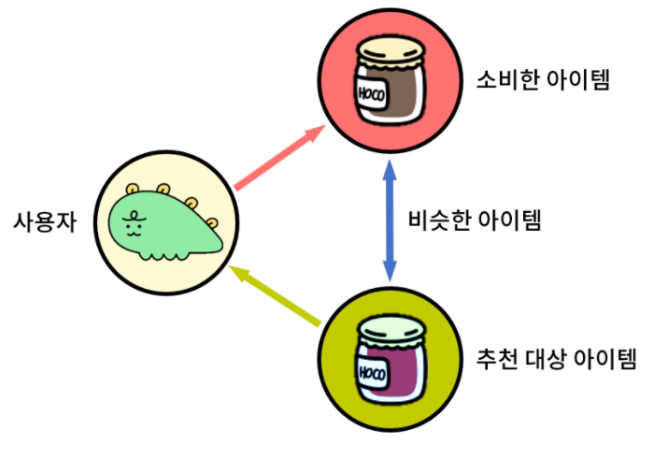

# [코사인 유사도](https://bkshin.tistory.com/entry/NLP-8-%EB%AC%B8%EC%84%9C-%EC%9C%A0%EC%82%AC%EB%8F%84-%EC%B8%A1%EC%A0%95-%EC%BD%94%EC%82%AC%EC%9D%B8-%EC%9C%A0%EC%82%AC%EB%8F%84)

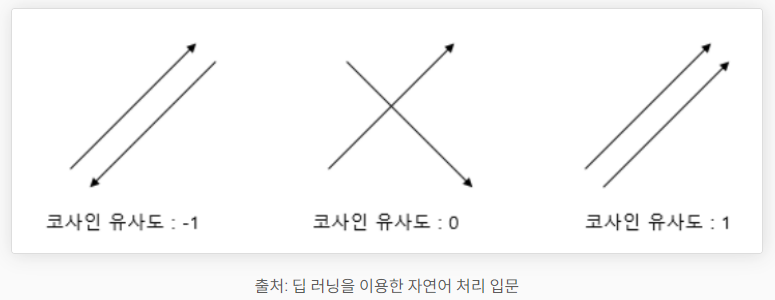

## 예제 데이터 

In [1]:
doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

print(f'문장 수: {len(doc_list)}')
doc_list

문장 수: 3


['if you take the blue pill, the story ends',
 'if you take the red pill, you stay in Wonderland',
 'if you take the red pill, I show you how deep the rabbit hole goes']

### 벡터화 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)

print(feature_vect_simple.shape)
feature_vect_simple

(3, 18)


<3x18 sparse matrix of type '<class 'numpy.float64'>'
	with 29 stored elements in Compressed Sparse Row format>

## 예제1

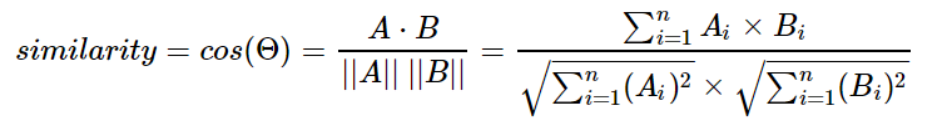

In [3]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2) # 분자: A * B
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2)))) # 분모: ||A|| ||B||
    similarity = dot_product / l2_norm     
    
    return similarity

TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 

In [4]:
feature_vect_dense = feature_vect_simple.todense()
print(feature_vect_dense.shape)
feature_vect_dense

(3, 18)


matrix([[0.4155636 , 0.        , 0.4155636 , 0.        , 0.        ,
         0.        , 0.24543856, 0.        , 0.24543856, 0.        ,
         0.        , 0.        , 0.        , 0.4155636 , 0.24543856,
         0.49087711, 0.        , 0.24543856],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.23402865, 0.39624495, 0.23402865, 0.        ,
         0.3013545 , 0.        , 0.39624495, 0.        , 0.23402865,
         0.23402865, 0.39624495, 0.4680573 ],
        [0.        , 0.30985601, 0.        , 0.30985601, 0.30985601,
         0.30985601, 0.18300595, 0.        , 0.18300595, 0.30985601,
         0.23565348, 0.30985601, 0.        , 0.        , 0.18300595,
         0.3660119 , 0.        , 0.3660119 ]])

첫번째 문장과 두번째 문장의 feature vector  추출

In [5]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

vect1.shape, vect2.shape 

((18,), (18,))

첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출

In [6]:
similarity_simple = cos_similarity(vect1, vect2)
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


## 예제2 with sklearn

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

첫번째 문장과 나머지 문장의 코사인 유사도를 측정

In [8]:
similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


각각 문장들 간의 유사도 측정 

In [9]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]


각 문장들 간의 유사도가 높은 순으로 정렬 
- 0번째 문장은 2번째 문장, 1번째 문장 순으로 유사함 
- 1번째 문장은 2번째 문장, 0번째 문장 순으로 유사함 
- 2번째 문장은 1번재 문장, 0번째 문장 순으로 유사함  

In [10]:
similarity_simple_pair.argsort() # 문장별 유사한 문장 정보들 

array([[1, 2, 0],
       [0, 2, 1],
       [0, 1, 2]])

In [11]:
similarity_simple_pair.argsort()[:, ::-1] # 문장별 가장 유사한 순서로 정렬 

array([[0, 2, 1],
       [1, 2, 0],
       [2, 1, 0]])

In [12]:
similarity_simple_pair.argsort()[:, ::-1][:, 1:] # 첫번째 데이터는 자기 자신임으로 제외함 

array([[2, 1],
       [2, 0],
       [1, 0]])

# [Movie Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv)



In [13]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/4. RS Pytorch/data/Movie/"

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


The tmdb_5000_movies has the following features:    

- budget:   
The budget in which the movie was made.
- genre:   
The genre of the movie, Action, comedy, Thriller etc.
- homepage:   
A link to the homepage of the movie.
- id:    
This is infact the movie_id as in the first dataset.
- keywords:   
The keywords or tags related to the movie.
- original_language:   
The language in which the movie was made.
- original_title:   
The title of the movie before translation or adaptation.
- overview:   
A brief description of the movie.
- popularity:    
A numeric quantity specifying the movie popularity.
- production_companies:   
The production house of the movie.
- production_countries:    
The country in which it was produced.
- release_date:   
The date on which it was released.
- revenue:   
The worldwide revenue generated by the movie.
- runtime:   
The running time of the movie in minutes.
- status:   
Released or Rumored
- tagline:    
Movie's tagline.
- title:   
Title of the movie.
- vote_average:   
average ratings the movie recieved.
- vote_count:   
the count of votes recieved. 


In [15]:
movies = pd.read_csv(DATA_PATH+"tmdb_5000_movies.csv")

print(f'{movies.shape}')
movies.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


## 필요한 컬럼 선택 

In [16]:
movies = movies[['id', 'genres', 'overview', 'title', 'vote_average', 'vote_count']]

movies.head()

,id,genres,overview,title,vote_average,vote_count
0,19995,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","In the 22nd century, a paraplegic Marine is di...",Avatar,7.2,11800
1,285,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",A cryptic message from Bond’s past sends him o...,Spectre,6.3,4466
3,49026,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Following the death of District Attorney Harve...,The Dark Knight Rises,7.6,9106
4,49529,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","John Carter is a war-weary, former military ca...",John Carter,6.1,2124


In [17]:
movies[['genres']].head()

,genres
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam..."
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."


In [18]:
print(type(movies[['genres']].loc[0]))
movies[['genres']].loc[0]

<class 'pandas.core.series.Series'>


genres    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
Name: 0, dtype: object

In [19]:
movies[['genres']].loc[0].index

Index(['genres'], dtype='object')

In [20]:
genres_0 = movies[['genres']].loc[0].values
print(type(genres_0))
genres_0

<class 'numpy.ndarray'>


array(['[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'],
      dtype=object)

In [21]:
len(genres_0)

1

In [22]:
import json

json.loads(genres_0[0])

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [23]:
gnres_0_list = [ i['name'] for i in json.loads(genres_0[0])]
gnres_0_list

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

In [24]:
' '.join(gnres_0_list)

'Action Adventure Fantasy Science Fiction'

In [25]:
def genres_to_str(genres) -> str:
  try:
    # 1. genres 첫번째 값(str)을 json 리스트로 변경 
    _genres_list = json.loads(genres)
    # 2. name값을 가져옴 
    _genres_list = [ i['name'] for i in _genres_list]
    # 3. list to str 
    _genres_str = ' '.join(_genres_list)
    return _genres_str
  except: 
    return genres

In [26]:
movies['genres'].map(lambda x: genres_to_str(x))[:5]

0    Action Adventure Fantasy Science Fiction
1                    Adventure Fantasy Action
2                      Action Adventure Crime
3                 Action Crime Drama Thriller
4            Action Adventure Science Fiction
Name: genres, dtype: object

## 결측치 확인 

In [27]:
(movies.isnull().sum() / movies.shape[0]).round(4).sort_values(ascending=False) # 각 걸럼별 결측치 비율

overview        0.0006
id              0.0000
genres          0.0000
title           0.0000
vote_average    0.0000
vote_count      0.0000
dtype: float64

In [28]:
movies = movies.dropna()

(movies.isnull().sum() / movies.shape[0]).round(4).sort_values(ascending=False) # 각 걸럼별 결측치 비율

id              0.0
genres          0.0
overview        0.0
title           0.0
vote_average    0.0
vote_count      0.0
dtype: float64

## genres 가공 

`literal_eval` 함수를 이용하면 각 문자열을 문자열이 의미하는 `list[dic1, dic2]` 객체로 만들 수 있습니다. 

In [29]:
movies['genres'] = movies['genres'].apply(literal_eval)
movies.head()

,id,genres,overview,title,vote_average,vote_count
0,19995,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","In the 22nd century, a paraplegic Marine is di...",Avatar,7.2,11800
1,285,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",A cryptic message from Bond’s past sends him o...,Spectre,6.3,4466
3,49026,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Following the death of District Attorney Harve...,The Dark Knight Rises,7.6,9106
4,49529,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","John Carter is a war-weary, former military ca...",John Carter,6.1,2124


name에 있는 genres를 추출합니다.

In [30]:
movies['genres'] = movies['genres'].map(lambda x: [y['name'] for y in x])
movies.head()

,id,genres,overview,title,vote_average,vote_count
0,19995,"[Action, Adventure, Fantasy, Science Fiction]","In the 22nd century, a paraplegic Marine is di...",Avatar,7.2,11800
1,285,"[Adventure, Fantasy, Action]","Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,"[Action, Adventure, Crime]",A cryptic message from Bond’s past sends him o...,Spectre,6.3,4466
3,49026,"[Action, Crime, Drama, Thriller]",Following the death of District Attorney Harve...,The Dark Knight Rises,7.6,9106
4,49529,"[Action, Adventure, Science Fiction]","John Carter is a war-weary, former military ca...",John Carter,6.1,2124


In [31]:
movies['genres'] = movies['genres'].apply(lambda x: (' ').join(x))
movies.head()

,id,genres,overview,title,vote_average,vote_count
0,19995,Action Adventure Fantasy Science Fiction,"In the 22nd century, a paraplegic Marine is di...",Avatar,7.2,11800
1,285,Adventure Fantasy Action,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Action Adventure Crime,A cryptic message from Bond’s past sends him o...,Spectre,6.3,4466
3,49026,Action Crime Drama Thriller,Following the death of District Attorney Harve...,The Dark Knight Rises,7.6,9106
4,49529,Action Adventure Science Fiction,"John Carter is a war-weary, former military ca...",John Carter,6.1,2124


# Model V0 with Score

## 가중 평점(Weighted Rating)
$$
가중 평점 = \left({ v \over v+m }\right) * R + \left({ m \over v+m }\right) * C 
$$
- $v$: 영화에 평가를 매긴 횟수 
- $m$: 평점을 부여하기 위한 최소 평가 수 
- $R$: 영화의 평균 평점 
- $C$: 전체 영화의 평균 평점 

In [32]:
percentile = 0.6 # 상위 60%의 횟수 
m = movies['vote_count'].quantile(percentile) # 평점을 부여하기 위한 최소 평가 수(즉, 상위 60%에 해당하는 평가 수만 인정)
C = movies['vote_average'].mean() # 전체 영화의 평균 평점 

def weighted_rating(record):
  v = record['vote_count'] # 영화에 평가를 매긴 횟수 
  R = record['vote_average'] # 영화의 평균 평점 

  return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )  # 가중 평점 계산 식 

In [33]:
movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)

print(f'{movies.shape}')
movies.head()

(4800, 7)


,id,genres,overview,title,vote_average,vote_count,weighted_rating
0,19995,Action Adventure Fantasy Science Fiction,"In the 22nd century, a paraplegic Marine is di...",Avatar,7.2,11800,7.166254
1,285,Adventure Fantasy Action,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9,4500,6.838528
2,206647,Action Adventure Crime,A cryptic message from Bond’s past sends him o...,Spectre,6.3,4466,6.284117
3,49026,Action Crime Drama Thriller,Following the death of District Attorney Harve...,The Dark Knight Rises,7.6,9106,7.541002
4,49529,Action Adventure Science Fiction,"John Carter is a war-weary, former military ca...",John Carter,6.1,2124,6.098947


## 추천 

In [34]:
movies[['title', 'weighted_rating', 'vote_average', 'vote_count']].sort_values(['weighted_rating', 'vote_average', 'vote_count'], ascending=False)[:10]

,title,weighted_rating,vote_average,vote_count
1881,The Shawshank Redemption,8.395869,8.5,8205
3337,The Godfather,8.263358,8.4,5893
662,Fight Club,8.216309,8.3,9413
3232,Pulp Fiction,8.206941,8.3,8428
65,The Dark Knight,8.136820,8.2,12002
1818,Schindler's List,8.125781,8.3,4329
3865,Whiplash,8.122956,8.3,4254
809,Forrest Gump,8.105793,8.2,7927
2294,Spirited Away,8.105550,8.3,3840
2731,The Godfather: Part II,8.079232,8.3,3338


# [Model V1 with Count](https://hipster4020.tistory.com/113)

In [35]:
df_movies = movies.copy()
df_movies.head()

,id,genres,overview,title,vote_average,vote_count,weighted_rating
0,19995,Action Adventure Fantasy Science Fiction,"In the 22nd century, a paraplegic Marine is di...",Avatar,7.2,11800,7.166254
1,285,Adventure Fantasy Action,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9,4500,6.838528
2,206647,Action Adventure Crime,A cryptic message from Bond’s past sends him o...,Spectre,6.3,4466,6.284117
3,49026,Action Crime Drama Thriller,Following the death of District Attorney Harve...,The Dark Knight Rises,7.6,9106,7.541002
4,49529,Action Adventure Science Fiction,"John Carter is a war-weary, former military ca...",John Carter,6.1,2124,6.098947


## CountVectorizer 
단어들의 카운트(출현 빈도)로 여러 문서들을 벡터화한다.  

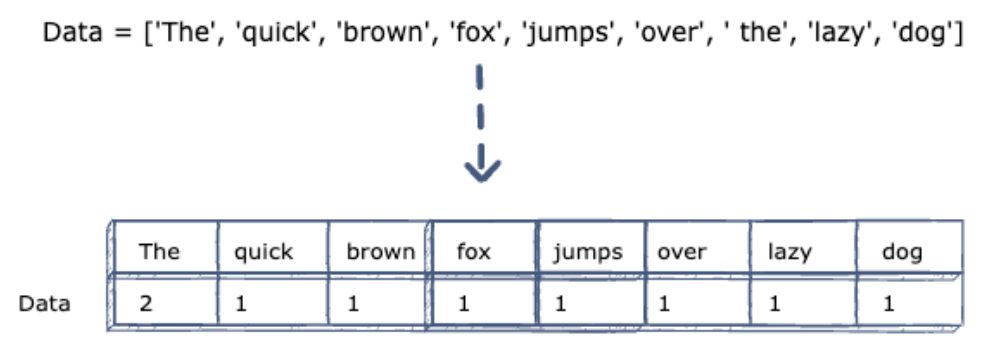

In [36]:
# min_df는 너무 드물게로 나타나는 용어를 제거하는 데 사용(min_df = 0.01은 문서의 1% 미만에 나타나는 용어를 무시)
# ngram_range는 n-그램 범위 
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2)) 

genre_mat = count_vect.fit_transform(df_movies['genres'])
print(genre_mat.shape)

(4800, 276)


In [37]:
len(count_vect.vocabulary_.keys())

276

In [38]:
count_vect.vocabulary_

{'action': 0,
 'adventure': 16,
 'fantasy': 124,
 'science': 232,
 'fiction': 138,
 'action adventure': 1,
 'adventure fantasy': 24,
 'fantasy science': 135,
 'science fiction': 233,
 'fantasy action': 125,
 'crime': 64,
 'adventure crime': 20,
 'drama': 90,
 'thriller': 234,
 'action crime': 4,
 'crime drama': 68,
 'drama thriller': 106,
 'adventure science': 29,
 'animation': 33,
 'family': 109,
 'animation family': 38,
 'fantasy family': 130,
 'action science': 12,
 'adventure action': 17,
 'action thriller': 13,
 'thriller crime': 238,
 'western': 265,
 'adventure western': 32,
 'adventure family': 23,
 'family fantasy': 115,
 'fiction action': 139,
 'action fantasy': 7,
 'comedy': 44,
 'action comedy': 3,
 'comedy science': 59,
 'adventure drama': 22,
 'drama action': 91,
 'romance': 214,
 'drama romance': 104,
 'romance thriller': 228,
 'thriller action': 235,
 'fiction thriller': 150,
 'adventure thriller': 30,
 'fantasy adventure': 126,
 'family adventure': 111,
 'adventure com

In [39]:
genre_mat.toarray()

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 유사도 측정

피처 벡터 행렬을 코사인 유사도는 사이킷런의 cosine_similarity()를 이용하여 측정할 수 있습니다. 아래 그림은 코사인 유사도를 행렬 형태로 변환되는 것을 표현한 것이다.

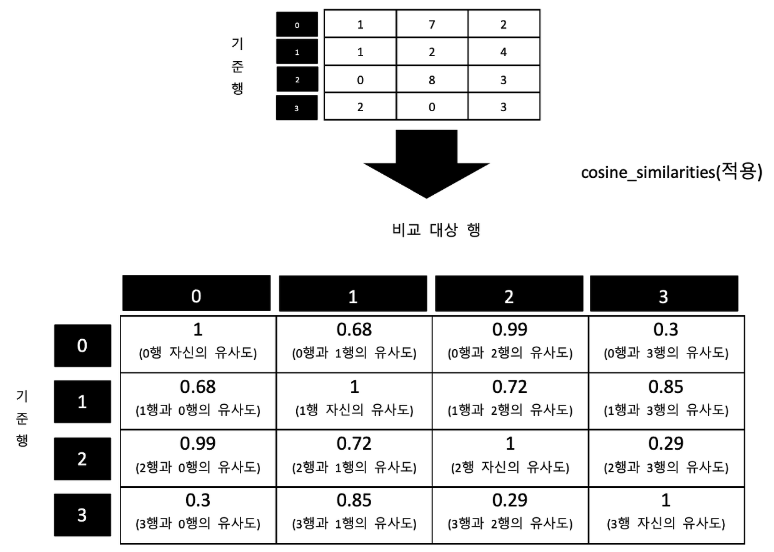

In [40]:
genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)

(4800, 4800)


In [41]:
genre_sim[0]

array([1.        , 0.59628479, 0.4472136 , ..., 0.        , 0.        ,
       0.        ])

In [42]:
genre_sim[1]

array([0.59628479, 1.        , 0.4       , ..., 0.        , 0.        ,
       0.        ])

피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교하여 유사도가 높은 영화 중 평점이 높은 순으로 추천

In [43]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1] # 유사도가 높은 순서로 정렬 

In [44]:
genre_sim_sorted_ind.shape 

(4800, 4800)

In [45]:
genre_sim_sorted_ind[:3]

array([[   0,   46,  813, ..., 3037, 3036, 2399],
       [ 329,  129,    1, ..., 3066, 3065, 2399],
       [1542,    2, 1740, ..., 2998, 2997, 2399]])

## 추천

In [46]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values 

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  # reshape(-1) 1차열 배열 반환 
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외 
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_rating가 높은 순으로 top_n 만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_rating', ascending=False)[:top_n]

노인을 위한 나라는 없다(No Country for Old Men)을 기준으로 추천해보자

In [47]:
similar_movies = find_sim_movie(df_movies, genre_sim_sorted_ind, 'No Country for Old Men', 10)

In [48]:
similar_movies[['title', 'vote_count', 'weighted_rating']]

,title,vote_count,weighted_rating
918,Inside Man,1630,7.076198
2545,End of Watch,1170,6.933467
1328,The Town,1468,6.817005
4226,Nine Queens,153,6.474565
3504,11:14,206,6.345359
2240,A Most Violent Year,546,6.335302
2502,Zulu,172,6.285216
717,Jack Reacher,2998,6.277196
944,Absolute Power,223,6.208202
4287,Niagara,79,6.199494


# [Model V2 with TF-IDF](https://www.kaggle.com/code/eslam101ahmed/tf-idf-movie-recommendation-system)

In [49]:
df_movies = movies.copy()
df_movies.head()

,id,genres,overview,title,vote_average,vote_count,weighted_rating
0,19995,Action Adventure Fantasy Science Fiction,"In the 22nd century, a paraplegic Marine is di...",Avatar,7.2,11800,7.166254
1,285,Adventure Fantasy Action,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,6.9,4500,6.838528
2,206647,Action Adventure Crime,A cryptic message from Bond’s past sends him o...,Spectre,6.3,4466,6.284117
3,49026,Action Crime Drama Thriller,Following the death of District Attorney Harve...,The Dark Knight Rises,7.6,9106,7.541002
4,49529,Action Adventure Science Fiction,"John Carter is a war-weary, former military ca...",John Carter,6.1,2124,6.098947


In [50]:
df_movies.isnull().sum().sum()

0

## TfidfVectorizer
TF-IDF(Term Frequency - Inverse Document Frequency) 인코딩은 단어를 갯수 그대로 카운트하지 않고 모든 문서에 공통적으로 들어있는 단어의 경우 문서 구별 능력이 떨어진다고 보아 가중치를 축소하는 방법이다.

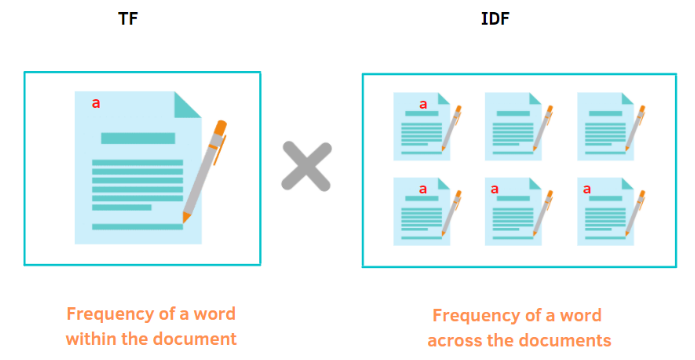

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
df_movies['features'] = df_movies['genres'] + df_movies['overview']

In [53]:
tfidf_vect_simple = TfidfVectorizer(stop_words='english')

genre_mat = tfidf_vect_simple.fit_transform(df_movies['features'])
print(genre_mat.shape)

(4800, 22942)


In [54]:
genre_vector = genre_mat.toarray()
genre_vector.shape

(4800, 22942)

## 유사도 측정 

In [55]:
similarity = cosine_similarity(genre_vector)
print(similarity.shape)

(4800, 4800)


In [56]:
genre_sim[0]

array([1.        , 0.59628479, 0.4472136 , ..., 0.        , 0.        ,
       0.        ])

In [57]:
pd.DataFrame(similarity, index=df_movies['title'], columns=df_movies['title'])

title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
title,,,,,,,,,,,,,,,,,,,,,
Avatar,1.000000,0.033295,0.016659,0.004657,0.023364,0.047485,0.004191,0.070002,0.030011,0.013298,...,0.000000,0.000000,0.027402,0.048394,0.000000,0.004872,0.000000,0.000000,0.000000,0.000000
Pirates of the Caribbean: At World's End,0.033295,1.000000,0.010580,0.000000,0.008768,0.015046,0.000000,0.037665,0.033054,0.008446,...,0.000000,0.000000,0.006517,0.000000,0.000000,0.000000,0.000000,0.020029,0.000000,0.000000
Spectre,0.016659,0.010580,1.000000,0.003975,0.011782,0.005078,0.003577,0.052020,0.032467,0.011349,...,0.027075,0.000000,0.000000,0.000000,0.017961,0.004158,0.000000,0.014256,0.000000,0.000000
The Dark Knight Rises,0.004657,0.000000,0.003975,1.000000,0.013312,0.008350,0.014744,0.033123,0.019247,0.133856,...,0.000000,0.000000,0.000000,0.002541,0.000000,0.007386,0.000000,0.034944,0.042308,0.021967
John Carter,0.023364,0.008768,0.011782,0.013312,1.000000,0.004208,0.011979,0.060581,0.007903,0.025564,...,0.012397,0.000000,0.000000,0.007061,0.000000,0.003445,0.000000,0.005846,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
El Mariachi,0.004872,0.000000,0.004158,0.007386,0.003445,0.003507,0.002471,0.017951,0.026362,0.003319,...,0.000000,0.010893,0.000000,0.000000,0.003148,1.000000,0.000000,0.000000,0.008444,0.000000
Newlyweds,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.006365,0.000000,0.000000
"Signed, Sealed, Delivered",0.000000,0.020029,0.014256,0.034944,0.005846,0.017530,0.000000,0.000000,0.027390,0.015164,...,0.010819,0.000000,0.015105,0.020768,0.000000,0.000000,0.006365,1.000000,0.023308,0.006711


## 추천 

In [58]:
def recommend(movie):
    movie_index = df_movies[df_movies['title'] == movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)),reverse=True, key=lambda x:x[1])[1:16] # list(영화에 대한 인덱스, 영화에 대한 유사도)
    mov=[]
    id=[]
    scores=[]
    for i in movies_list:
        mov.append(df_movies.iloc[i[0]].title)
        id.append(df_movies.iloc[i[0]].id)
        scores.append(i[1])
    dic={'movie_id':id,'title':mov,'Similarity Score':scores}
    return pd.DataFrame(dic) 

In [59]:
movie_index = df_movies[df_movies['title'] == 'Alice in Wonderland'].index[0]
movie_index

32

In [60]:
# we get the similarities for the movie
distances = similarity[32] 
# we sort the similarities in descending order
sorted(distances,reverse=True)[0:10]

[1.0,
 0.11893635159322954,
 0.1167416315189592,
 0.10871827531005854,
 0.09532551010124352,
 0.08785342808282803,
 0.08778469372879466,
 0.07923234985222011,
 0.07054080084793585,
 0.06909427794903468]

In [61]:
num=3
movies_list = sorted(list(enumerate(distances)),reverse=True, key=lambda x:x[1])[1:num+1]
movies_list

[(2294, 0.11893635159322954),
 (3328, 0.1167416315189592),
 (105, 0.10871827531005854)]

In [62]:
movie_name='Pirates of the Caribbean: On Stranger Tides'
popular_movies = recommend(movie_name) 
popular_movies

,movie_id,title,Similarity Score
0,266647,Pan,0.159006
1,22,Pirates of the Caribbean: The Curse of the Bla...,0.152266
2,9754,Firewall,0.151294
3,9280,Femme Fatale,0.147874
4,18808,Highway,0.145389
5,9869,Patriot Games,0.143870
6,58,Pirates of the Caribbean: Dead Man's Chest,0.130419
7,9593,Last Action Hero,0.128641
8,16205,Jack Brooks: Monster Slayer,0.115456
9,11968,Into the Blue,0.105665


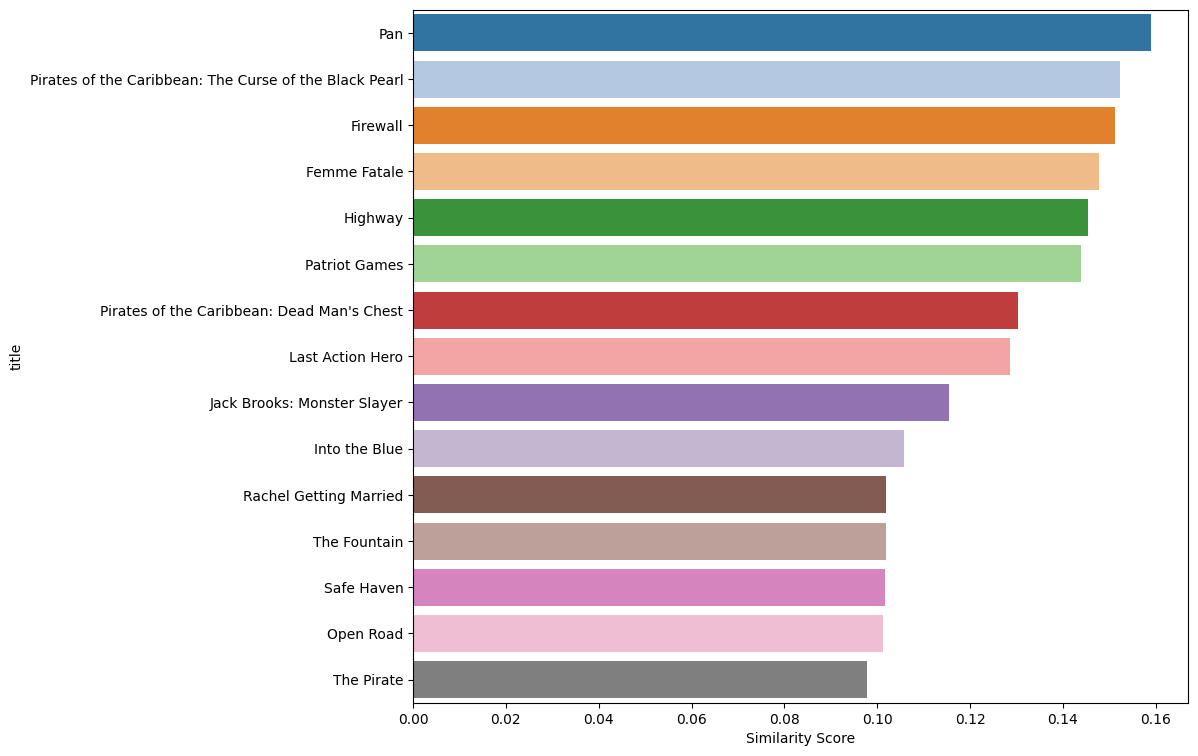

In [63]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 9)
sns.barplot(x=popular_movies['Similarity Score'],y=popular_movies['title'],palette='tab20')
plt.show();

In [67]:
def recommend_v2(movie, top_n=10):
    movie_index = df_movies[df_movies['title'] == movie].index[0]
    distances = similarity[movie_index]
    movies_list = sorted(list(enumerate(distances)),reverse=True, key=lambda x:x[1])[1:top_n*2] # list(영화에 대한 인덱스, 영화에 대한 유사도)
    mov=[]
    id=[]
    rating=[]
    scores=[]
    for i in movies_list:
        mov.append(df_movies.iloc[i[0]].title)
        id.append(df_movies.iloc[i[0]].id)
        rating.append(df_movies.iloc[i[0]].weighted_rating)
        scores.append(i[1])
        
    # 추천 데이터 프레임 생성 
    dic={'movie_id':id,'title':mov,'Similarity Score':scores, 'weighted_rating':rating}
    df_recommend = pd.DataFrame(dic) 

    return df_recommend.sort_values('weighted_rating', ascending=False)[:top_n]

In [68]:
movie_name='Pirates of the Caribbean: On Stranger Tides'
popular_movies2 = recommend_v2(movie_name) 
popular_movies2

,movie_id,title,Similarity Score,weighted_rating
1,22,Pirates of the Caribbean: The Curse of the Bla...,0.152266,7.429034
6,58,Pirates of the Caribbean: Dead Man's Chest,0.130419,6.940088
12,112949,Safe Haven,0.101648,6.649223
11,1381,The Fountain,0.101907,6.581028
15,72197,The Pirates! In an Adventure with Scientists!,0.097332,6.247077
5,9869,Patriot Games,0.143870,6.204443
16,84355,Your Sister's Sister,0.096061,6.202701
3,9280,Femme Fatale,0.147874,6.122558
14,35032,The Pirate,0.097756,6.115134
7,9593,Last Action Hero,0.128641,6.097573


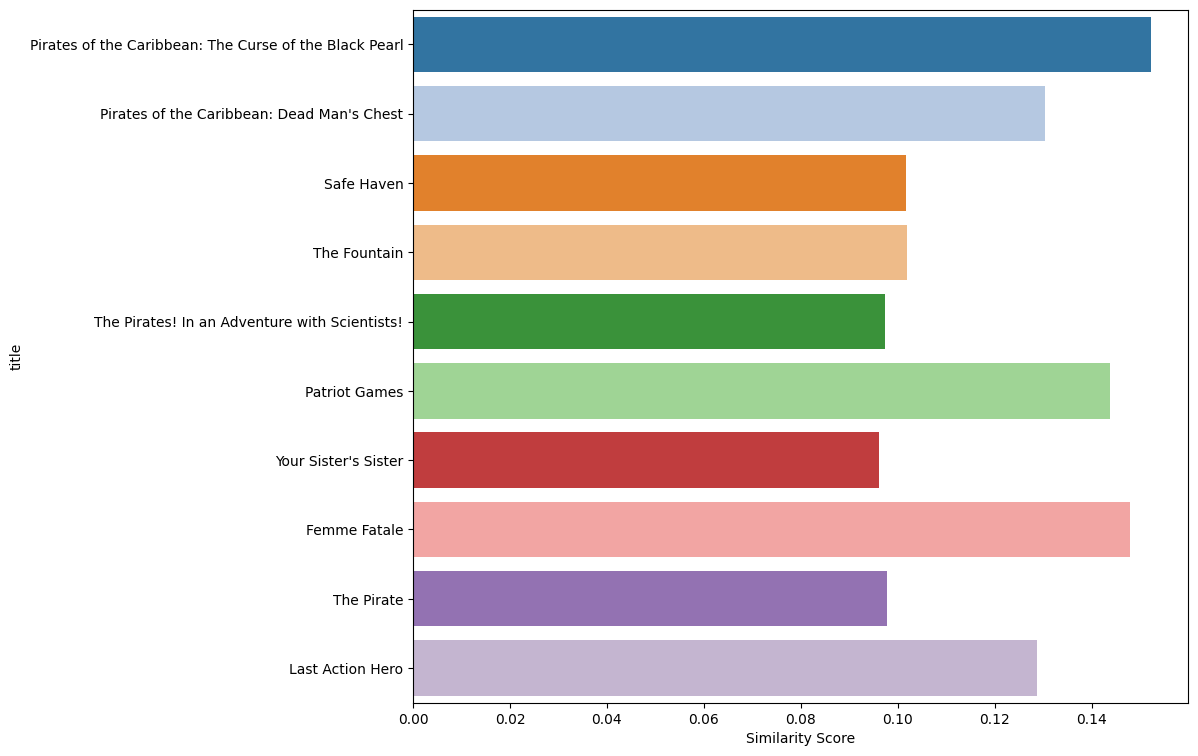

In [69]:
plt.rcParams['figure.figsize'] = (10, 9)
sns.barplot(x=popular_movies2['Similarity Score'],y=popular_movies2['title'],palette='tab20')
plt.show();

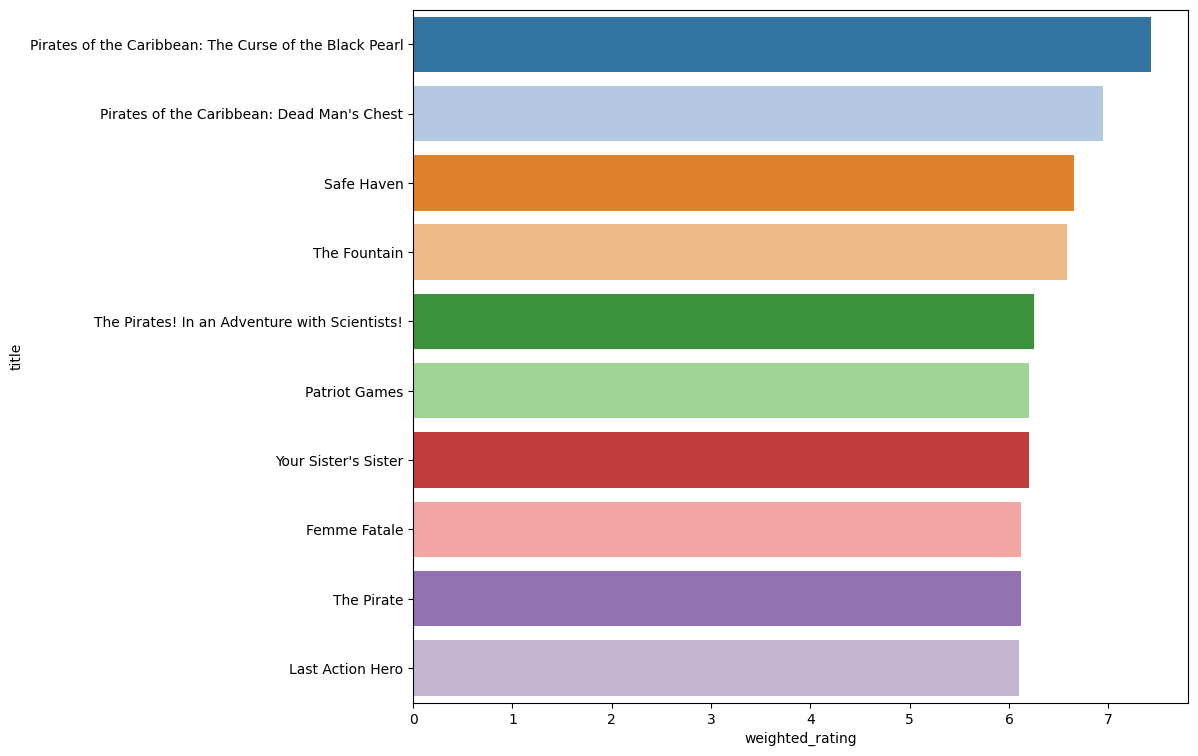

In [70]:
plt.rcParams['figure.figsize'] = (10, 9)
sns.barplot(x=popular_movies2['weighted_rating'],y=popular_movies2['title'],palette='tab20')
plt.show();